# MVP Comunidad Valenciana with Target Encoding

<img src="../images/03.jpg" width="600"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import datetime as dt
from tools import dataoveriew, plot_roc_curve, plot_confusion_matrix
from datetime import datetime
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pickle

# Using Activo and Baja for 0 and 1    
class_names = ['Activo','Baja']

pd.options.display.max_columns = None

%matplotlib inline

In [2]:
data = pd.read_excel('../data/portfolio_com_valencia.xlsx')
data['Cliente'] = data['Cliente'].astype('str')
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43


In [3]:
data.shape

(55227, 21)

## Feature engineering

- Edad en Años
- Rango de Ingresos
- Días Activo escalado
- Escalado de Quejas, Incidencias y Consumo Mes

Rangos de Edad:

In [4]:
data.columns

Index(['Fecha Alta', 'Cliente', 'Modelo Caldera', 'Provincia', 'Gender',
       'Pais', 'Born Date', 'Tipo Propiedad', 'Situacion Laboral',
       'Estado Civil', 'Ingresos', 'Pagos Anuales', 'Fecha Estado', 'Estado',
       'Tipo Inmueble', 'Financiado', 'Precio Contado', 'Precio Total',
       'Quejas', 'Incidencias', 'Consumo Mes'],
      dtype='object')

In [5]:
data['Born Date'].isnull().sum()

226

In [6]:
data['Born Date'] = data['Born Date'].replace(np.nan, datetime(1970, 1, 1))

data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43


In [7]:
data['Born Date'].isnull().sum()

0

In [8]:
# Edad en el momento del alta

data['Edad'] = ((data['Fecha Alta'] - data['Born Date']).dt.days)/365
                        
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356


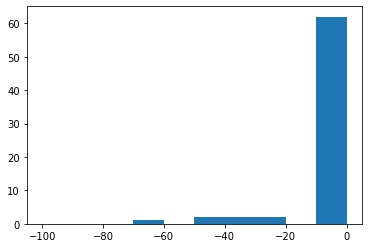

In [9]:
plt.hist(data['Edad'], range = (-100,0));

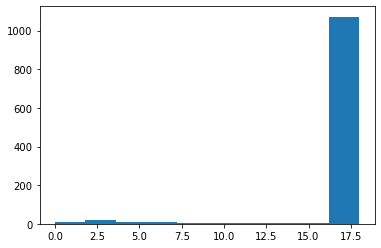

In [10]:
plt.hist(data['Edad'], range = (0,18));

In [11]:
edad_mean = data['Edad'].mean()
edad_mean

49.411166614701536

In [12]:
data['Edad'] = data['Edad'].apply(lambda x: edad_mean if x<18 else x)

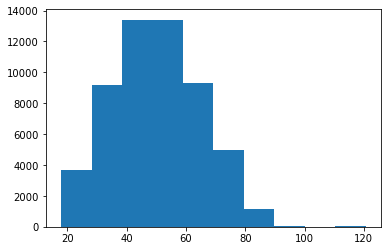

In [13]:
plt.hist(data['Edad']);

In [14]:
# Mapping Edad 
data.loc[data['Edad'] <= 30, 'Rango_Edad'] = "18-30"
data.loc[(data['Edad'] > 30) & (data['Edad'] <= 40), 'Rango_Edad'] = "30-40"
data.loc[(data['Edad'] > 40) & (data['Edad'] <= 50), 'Rango_Edad'] = "40-50"
data.loc[(data['Edad'] > 50) & (data['Edad'] <= 60), 'Rango_Edad'] = "50-60"
data.loc[(data['Edad'] > 60) & (data['Edad'] <= 70), 'Rango_Edad'] = "60-70"
data.loc[(data['Edad'] > 70) & (data['Edad'] <= 80), 'Rango_Edad'] = "70-80"
data.loc[data['Edad'] > 80, 'Rango_Edad'] = "+80"
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30


In [15]:
tab1 = pd.crosstab(data["Rango_Edad"], data["Estado"], margins = True)
tab2 = pd.crosstab(data["Rango_Edad"], data["Estado"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Estado,0,1,All,0,1
Rango_Edad,,,,,
+80,961,203,1164,0.825601,0.174399
18-30,2584,2258,4842,0.533664,0.466336
30-40,6163,3749,9912,0.621772,0.378228
40-50,10346,3941,14287,0.724155,0.275845
50-60,9324,2274,11598,0.803932,0.196068
60-70,7571,1276,8847,0.855770,0.144230
70-80,3988,589,4577,0.871313,0.128687
All,40937,14290,55227,0.741250,0.258750


Rangos de Ingresos:

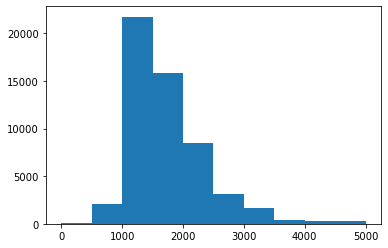

In [16]:
plt.hist(data['Ingresos'], range=(0, 5000));

In [17]:
data.loc[data['Ingresos'] <= 1000, 'Income'] = "0-1000"
data.loc[(data['Ingresos'] > 1000) & (data['Ingresos'] <= 1500), 'Income'] = "1000-1500"
data.loc[(data['Ingresos'] > 1500) & (data['Ingresos'] <= 2000), 'Income'] = "1500-2000"
data.loc[(data['Ingresos'] > 2000) & (data['Ingresos'] <= 3000), 'Income'] = "2000-3000"
data.loc[data['Ingresos'] > 3000, 'Income'] = "+3000"
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50,2000-3000
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40,1000-1500
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40,0-1000
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40,1000-1500
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30,0-1000


In [18]:
tab1 = pd.crosstab(data["Income"], data["Estado"], margins = True)
tab2 = pd.crosstab(data["Income"], data["Estado"], margins = True, normalize = 'index')
pd.concat([tab1, tab2], axis = 1)

Estado,0,1,All,0,1
Income,,,,,
+3000,1687,448,2135,0.790164,0.209836
0-1000,6979,3147,10126,0.689216,0.310784
1000-1500,18436,6408,24844,0.742071,0.257929
1500-2000,9482,3084,12566,0.754576,0.245424
2000-3000,4353,1203,5556,0.783477,0.216523
All,40937,14290,55227,0.741250,0.258750


Días Activo:

In [19]:
# Días hasta el 19/01/2021 (fecha de la extracción de datos) si ACTIVO y hasta cuando se dio de baja si BAJA

data['Dias_Activo'] = 0
fecha = datetime(2021, 1, 19)

for i in range(len(data['Fecha Alta'])):
    if data.loc[i, 'Estado'] == 0:
        data.loc[i,'Dias_Activo'] = (fecha - data.loc[i,'Fecha Alta']).days
    else:
        data.loc[i,'Dias_Activo'] = (data.loc[i,'Fecha Estado'] - data.loc[i,'Fecha Alta']).days
                        
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50,2000-3000,987
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40,1000-1500,1093
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40,0-1000,1150
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40,1000-1500,2575
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30,0-1000,1165


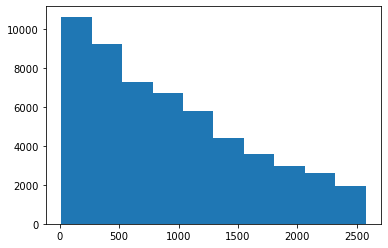

In [20]:
plt.hist(data['Dias_Activo']);

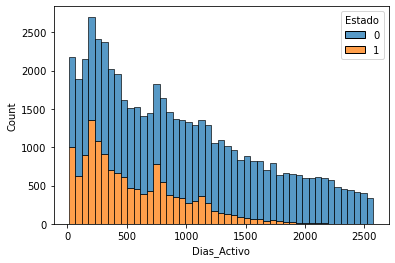

In [21]:
sns.histplot(data = data, x = 'Dias_Activo', hue = 'Estado', multiple = 'stack');

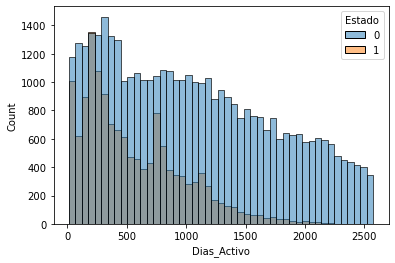

In [22]:
sns.histplot(data = data, x = 'Dias_Activo', hue = 'Estado');

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['Dias_Activo_sca'] = scaler.fit_transform(data['Dias_Activo'].values.reshape(-1, 1))

data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50,2000-3000,987,0.380172
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40,1000-1500,1093,0.421546
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40,0-1000,1150,0.443794
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40,1000-1500,2575,1.000000
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30,0-1000,1165,0.449649


In [24]:
filename = '../mvp_pkl/dias_activo_sca.pkl'
dias_activo_sca = scaler.fit(data['Dias_Activo'].values.reshape(-1, 1))

pickle.dump(dias_activo_sca, open(filename,'wb'))

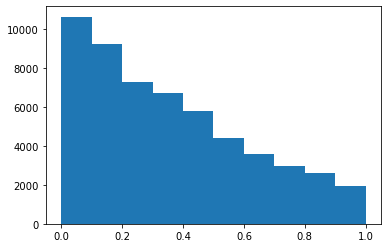

In [25]:
plt.hist(data['Dias_Activo_sca']);

Escalado de Quejas, Incidencias y Consumo Mes:

In [26]:
scaler = MinMaxScaler()
data['Quejas_sca'] = scaler.fit_transform(data['Quejas'].values.reshape(-1, 1))
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50,2000-3000,987,0.380172,0.035714
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40,1000-1500,1093,0.421546,0.000000
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40,0-1000,1150,0.443794,0.035714
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40,1000-1500,2575,1.000000,0.035714
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30,0-1000,1165,0.449649,0.000000


In [27]:
filename = '../mvp_pkl/quejas_sca.pkl'
quejas_sca = scaler.fit(data['Quejas'].values.reshape(-1, 1))

pickle.dump(quejas_sca, open(filename,'wb'))

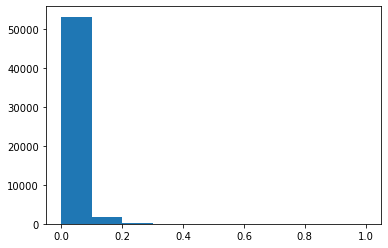

In [28]:
plt.hist(data['Quejas_sca']);

In [29]:
scaler = MinMaxScaler()
data['Incidencias_sca'] = scaler.fit_transform(data['Incidencias'].values.reshape(-1, 1))
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca,Incidencias_sca
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50,2000-3000,987,0.380172,0.035714,0.000000
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40,1000-1500,1093,0.421546,0.000000,0.000000
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40,0-1000,1150,0.443794,0.035714,0.000000
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40,1000-1500,2575,1.000000,0.035714,0.000000
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30,0-1000,1165,0.449649,0.000000,0.470588


In [30]:
filename = '../mvp_pkl/incidencias_sca.pkl'
mt_sca = scaler.fit(data['Incidencias'].values.reshape(-1, 1))

pickle.dump(mt_sca, open(filename,'wb'))

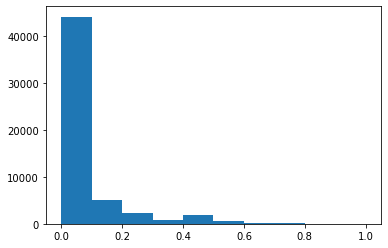

In [31]:
plt.hist(data['Incidencias_sca']);

In [32]:
scaler = MinMaxScaler()
data['Consumo_sca'] = scaler.fit_transform(data['Consumo Mes'].values.reshape(-1, 1))
data.head()

,Fecha Alta,Cliente,Modelo Caldera,Provincia,Gender,Pais,Born Date,Tipo Propiedad,Situacion Laboral,Estado Civil,Ingresos,Pagos Anuales,Fecha Estado,Estado,Tipo Inmueble,Financiado,Precio Contado,Precio Total,Quejas,Incidencias,Consumo Mes,Edad,Rango_Edad,Income,Dias_Activo,Dias_Activo_sca,Quejas_sca,Incidencias_sca,Consumo_sca
0,2014-01-01,17,Biasi,Alicante,Hombre,España,1973-05-19,Propiedad Total,Autonomo,Casado,2500,14,2016-09-14,1,Casa,Financiado,Promo 0 EUR,399,1,0,441.63,40.649315,40-50,2000-3000,987,0.380172,0.035714,0.000000,0.385207
1,2014-01-01,54,Biasi,Alicante,Hombre,España,1976-05-08,Propiedad Total,Parado,Soltero,1200,14,2016-12-29,1,Piso,Financiado,Promo 0 EUR,399,0,0,152.57,37.676712,30-40,1000-1500,1093,0.421546,0.000000,0.000000,0.133043
2,2014-01-01,84,Biasi,Valencia,Hombre,España,1982-03-15,Propiedad Total,Trabajo Temporal,Soltero,800,14,2017-02-24,1,Casa,Financiado,0 - 100 EUR,399,1,0,288.73,31.821918,30-40,0-1000,1150,0.443794,0.035714,0.000000,0.251823
3,2014-01-01,103,Biasi,Alicante,Hombre,España,1976-02-02,Propiedad Total,Autonomo,Casado,1500,12,2014-01-01,0,Casa,Financiado,Promo 0 EUR,399,1,0,103.97,37.939726,30-40,1000-1500,2575,1.000000,0.035714,0.000000,0.090647
4,2014-01-01,110,Biasi,Alicante,Mujer,España,1989-07-31,Propiedad Total,Parado,Soltero,1000,12,2017-03-11,1,Piso,Financiado,Promo 0 EUR,399,0,8,145.43,24.438356,18-30,0-1000,1165,0.449649,0.000000,0.470588,0.126815


In [33]:
filename = '../mvp_pkl/consumo_sca.pkl'
consumo_sca = scaler.fit(data['Consumo Mes'].values.reshape(-1, 1))

pickle.dump(consumo_sca, open(filename,'wb'))

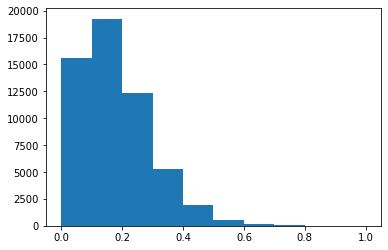

In [34]:
plt.hist(data['Consumo_sca']);

## Enconding con ``target encoding``

In [35]:
data.columns

Index(['Fecha Alta', 'Cliente', 'Modelo Caldera', 'Provincia', 'Gender',
       'Pais', 'Born Date', 'Tipo Propiedad', 'Situacion Laboral',
       'Estado Civil', 'Ingresos', 'Pagos Anuales', 'Fecha Estado', 'Estado',
       'Tipo Inmueble', 'Financiado', 'Precio Contado', 'Precio Total',
       'Quejas', 'Incidencias', 'Consumo Mes', 'Edad', 'Rango_Edad', 'Income',
       'Dias_Activo', 'Dias_Activo_sca', 'Quejas_sca', 'Incidencias_sca',
       'Consumo_sca'],
      dtype='object')

In [36]:
data_filtered = data[['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral', 'Estado Civil', 
                      'Provincia', 'Pais', 'Rango_Edad', 'Income', 'Precio Contado', 'Pagos Anuales', 'Precio Total',
                      'Quejas_sca', 'Incidencias_sca', 'Consumo_sca', 'Estado']]
data_filtered.columns

Index(['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral',
       'Estado Civil', 'Provincia', 'Pais', 'Rango_Edad', 'Income',
       'Precio Contado', 'Pagos Anuales', 'Precio Total', 'Quejas_sca',
       'Incidencias_sca', 'Consumo_sca', 'Estado'],
      dtype='object')

In [37]:
X = data_filtered.drop(['Estado'],axis=1)
y = data_filtered['Estado']

In [38]:
from sklearn.model_selection import train_test_split
X_train_prev, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [39]:
features_TE = ['Gender', 'Tipo Inmueble', 'Tipo Propiedad', 'Situacion Laboral', 'Estado Civil', 'Precio Total',
               'Provincia', 'Pais', 'Rango_Edad', 'Income', 'Precio Contado', 'Pagos Anuales']

In [40]:
from category_encoders import TargetEncoder

TE_encoder = TargetEncoder(cols=features_TE)

In [41]:
X_train_prev.head()

,Gender,Tipo Inmueble,Tipo Propiedad,Situacion Laboral,Estado Civil,Provincia,Pais,Rango_Edad,Income,Precio Contado,Pagos Anuales,Precio Total,Quejas_sca,Incidencias_sca,Consumo_sca
25918,Hombre,Casa,Propiedad Total,Jubilado,Casado,Alicante,España,60-70,0-1000,0 - 100 EUR,12,399,0.035714,0.000000,0.234751
5305,Hombre,Piso,Empresa,Autonomo,Casado,Alicante,España,40-50,1000-1500,0 - 100 EUR,14,399,0.000000,0.000000,0.059634
38504,Hombre,Casa,Propiedad Total,Trabajo Fijo,Casado,Alicante,Union Europea,40-50,1500-2000,0 - 100 EUR,14,399,0.000000,0.000000,0.299881
35496,Hombre,Piso,Propiedad Total,Jubilado,Viudo,Alicante,España,+80,1000-1500,100 - 200 EUR,12,499,0.000000,0.000000,0.061728
8046,Hombre,Piso,Propiedad Total,Autonomo,Casado,Valencia,España,60-70,1000-1500,100 - 200 EUR,14,499,0.000000,0.117647,0.081836


In [42]:
TE_encoder.fit(X_train_prev, y_train)
X_train = TE_encoder.transform(X_train_prev)
X_train.head()

C:\Users\alber\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Gender,Tipo Inmueble,Tipo Propiedad,Situacion Laboral,Estado Civil,Provincia,Pais,Rango_Edad,Income,Precio Contado,Pagos Anuales,Precio Total,Quejas_sca,Incidencias_sca,Consumo_sca
25918,0.2536,0.207625,0.229333,0.144286,0.219828,0.220812,0.254659,0.145050,0.311213,0.326792,0.282987,0.312914,0.035714,0.000000,0.234751
5305,0.2536,0.210947,0.272727,0.337908,0.219828,0.220812,0.254659,0.277612,0.257715,0.326792,0.234842,0.312914,0.000000,0.000000,0.059634
38504,0.2536,0.207625,0.229333,0.219986,0.219828,0.220812,0.250320,0.277612,0.244343,0.326792,0.234842,0.312914,0.000000,0.000000,0.299881
35496,0.2536,0.210947,0.229333,0.144286,0.183570,0.220812,0.254659,0.163866,0.257715,0.237826,0.282987,0.250299,0.000000,0.000000,0.061728
8046,0.2536,0.210947,0.229333,0.337908,0.219828,0.272935,0.254659,0.145050,0.257715,0.237826,0.234842,0.250299,0.000000,0.117647,0.081836


In [43]:
filename = '../mvp_pkl/TE_encoder.pkl'

pickle.dump(TE_encoder.fit(X_train_prev, y_train), open(filename,'wb'))

C:\Users\alber\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [44]:
X_test = TE_encoder.transform(X_test)
X_test.head()

,Gender,Tipo Inmueble,Tipo Propiedad,Situacion Laboral,Estado Civil,Provincia,Pais,Rango_Edad,Income,Precio Contado,Pagos Anuales,Precio Total,Quejas_sca,Incidencias_sca,Consumo_sca
15591,0.253600,0.210947,0.229333,0.337908,0.370321,0.272935,0.254659,0.196224,0.244343,0.326792,0.282987,0.312914,0.000000,0.000000,0.107919
27726,0.278034,0.210947,0.229333,0.337908,0.370321,0.272935,0.254659,0.378727,0.257715,0.185057,0.234842,0.195478,0.000000,0.000000,0.021408
16792,0.253600,0.207625,0.229333,0.460733,0.219828,0.220812,0.254659,0.196224,0.257715,0.326792,0.234842,0.312914,0.000000,0.000000,0.210002
23233,0.253600,0.210947,0.229333,0.337908,0.219828,0.343207,0.254659,0.378727,0.257715,0.308267,0.234842,0.312914,0.035714,0.411765,0.042248
24836,0.253600,0.207625,0.229333,0.219986,0.219828,0.343207,0.254659,0.378727,0.244343,0.237826,0.234842,0.250299,0.000000,0.000000,0.280463


### Regresión Logística

Logistic Accuracy is 0.73
Cross Validation Score = 0.73
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      8188
           1       0.48      0.70      0.57      2858

    accuracy                           0.73     11046
   macro avg       0.68      0.72      0.69     11046
weighted avg       0.78      0.73      0.74     11046



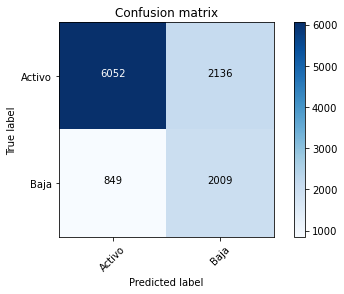

In [45]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state = 0, max_iter=1000, class_weight="balanced")
LR.fit(X_train,y_train) 
print ("Logistic Accuracy is %2.2f" % accuracy_score(y_test, LR.predict(X_test)))

skf = StratifiedKFold(n_splits=5)
score_LR = cross_val_score(LR, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_LR)

y_pred = LR.predict(X_test)
print(classification_report(y_test, y_pred))

# Almacenar el recall de '1' en una variable para mostrar resultados al final del notebook

result = classification_report(y_test, y_pred, output_dict=True)
recall_lr = round(result['1']['recall'], 4)

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.79


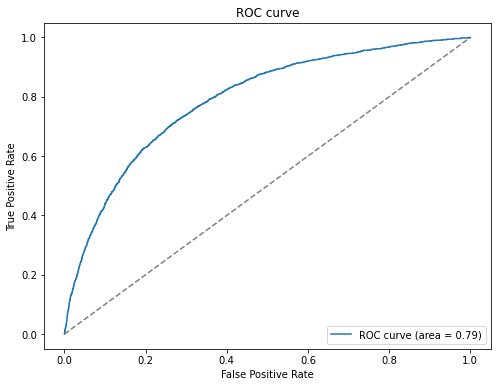

In [46]:
plot_roc_curve(LR, X_test, y_test)

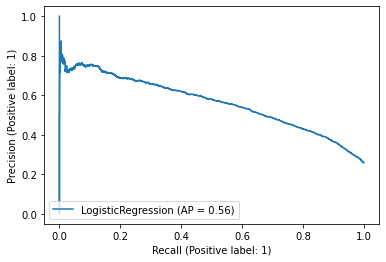

In [47]:
plot_precision_recall_curve(LR, X_test, y_test);

In [48]:
filename = '../mvp_pkl/LR_model.pkl'
LR_model = LR.fit(X_train, y_train)

pickle.dump(LR_model, open(filename,'wb'))

### KNN

In [49]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
# Don´t do this!!!

skf = StratifiedKFold(n_splits=5)
knn = GridSearchCV(KNeighborsClassifier(),
                      param_grid = {'n_neighbors':np.arange(3,17,2)},
                      scoring = 'recall', cv = skf)

knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15])},
             scoring='recall')

In [51]:
knn.best_params_

{'n_neighbors': 3}

In [50]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [51]:
y_pred = knn.predict(X_test)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      8188
           1       0.54      0.42      0.47      2858

    accuracy                           0.76     11046
   macro avg       0.67      0.65      0.66     11046
weighted avg       0.74      0.76      0.75     11046



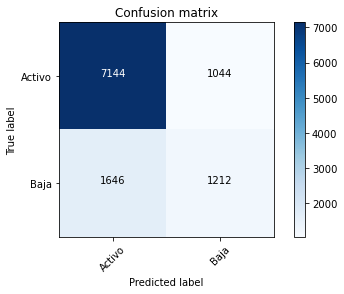

In [52]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test,y_pred))

result = classification_report(y_test, y_pred, output_dict=True)
recall_knn = round(result['1']['recall'], 4)

plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.71


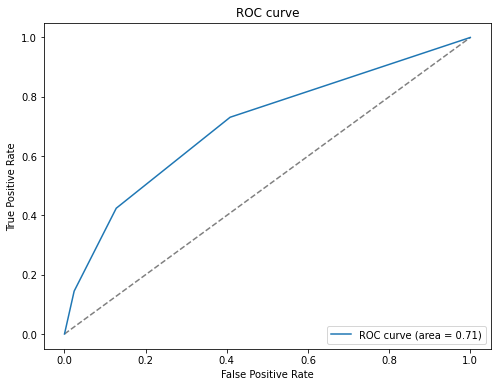

In [53]:
plot_roc_curve(knn, X_test, y_test)

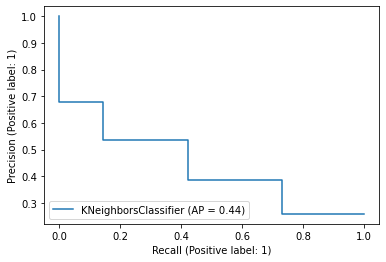

In [54]:
plot_precision_recall_curve(knn, X_test, y_test);

### Decission Tree Classifier

Decision Tree Accuracy is 0.72
Cross Validation Score = 0.71
              precision    recall  f1-score   support

           0       0.88      0.71      0.79      8188
           1       0.47      0.73      0.57      2858

    accuracy                           0.72     11046
   macro avg       0.68      0.72      0.68     11046
weighted avg       0.78      0.72      0.73     11046



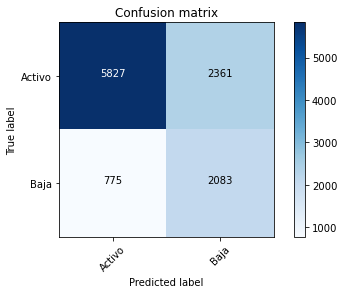

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

DT = DecisionTreeClassifier(random_state = 0,class_weight="balanced", min_weight_fraction_leaf=0.01)
DT = DT.fit(X_train,y_train)
print ("Decision Tree Accuracy is %2.2f" % accuracy_score(y_test, DT.predict(X_test)))

skf = StratifiedKFold(n_splits=5)
score_DT = cross_val_score(DT, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_DT)

y_pred = DT.predict(X_test)
print(classification_report(y_test, y_pred))

result = classification_report(y_test, y_pred, output_dict=True)
recall_dt = round(result['1']['recall'], 4)

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.79


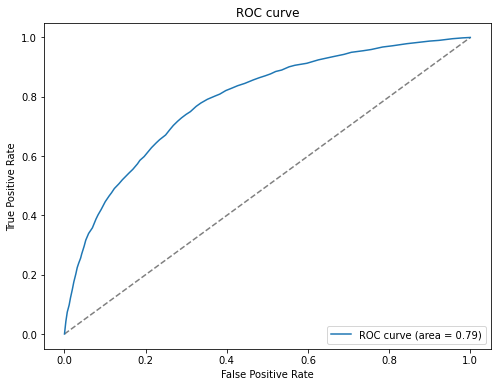

In [56]:
plot_roc_curve(DT, X_test, y_test)

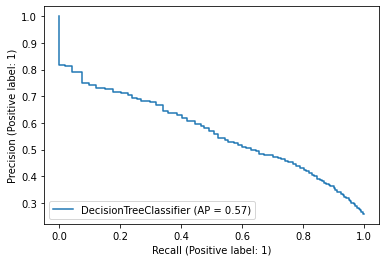

In [57]:
plot_precision_recall_curve(DT, X_test, y_test);

In [58]:
filename = '../mvp_pkl/DT_model.pkl'
DT_model = DT.fit(X_train, y_train)

pickle.dump(DT_model, open(filename,'wb'))

### Random Forest Classifier

Random Forest Accuracy is 0.78
Cross Validation Score = 0.78
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      8188
           1       0.58      0.61      0.59      2858

    accuracy                           0.78     11046
   macro avg       0.72      0.73      0.72     11046
weighted avg       0.79      0.78      0.79     11046



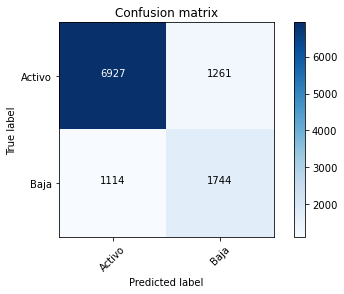

In [80]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=10,class_weight="balanced")
rfc.fit(X_train, y_train)
print("Random Forest Accuracy is %2.2f" % accuracy_score(y_test, rfc.predict(X_test)))

skf = StratifiedKFold(n_splits=20)
score_rfc = cross_val_score(rfc, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_rfc)

y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred ))

result = classification_report(y_test, y_pred, output_dict=True)
recall_rfc = round(result['1']['recall'], 4)

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.81


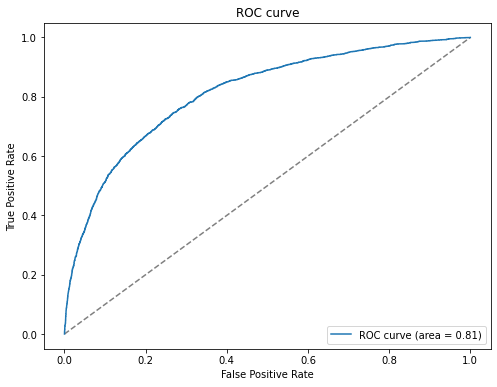

In [60]:
plot_roc_curve(rfc, X_test, y_test)

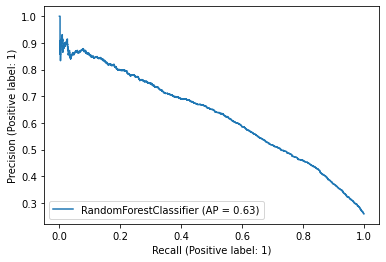

In [61]:
plot_precision_recall_curve(rfc, X_test, y_test);

#### Random Forest parameter tuning

In [78]:
# Don´t do this!!!

from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=3)

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, None],
    'max_features': ['auto', 5, 10],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [2, 5],
    'n_estimators': [100, 300]
}

rfc_2 = GridSearchCV(estimator = RandomForestClassifier(class_weight="balanced"), param_grid = param_grid, 
                          cv = skf, n_jobs = -1, verbose = 2, scoring = 'recall_macro')

rfc_2.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, None],
                         'max_features': ['auto', 5, 10],
                         'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 300]},
             scoring='recall_macro', verbose=2)

In [79]:
rfc_2.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 300}

Random Forest Accuracy is 0.77
Cross Validation Score = 0.77
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      8188
           1       0.55      0.64      0.60      2858

    accuracy                           0.77     11046
   macro avg       0.71      0.73      0.72     11046
weighted avg       0.79      0.77      0.78     11046



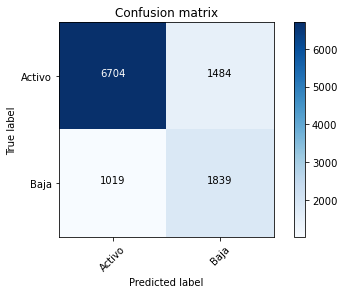

In [62]:
from sklearn.ensemble import RandomForestClassifier

rfc_2 = RandomForestClassifier(min_samples_leaf = 3, 
                                       min_samples_split = 5,
                                       max_depth = None,
                                       n_estimators = 300, 
                                       max_features = 'auto', 
                                       bootstrap = False, class_weight = "balanced")
rfc_2.fit(X_train, y_train)
y_pred = rfc_2.predict(X_test)

print("Random Forest Accuracy is %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=10)
score_rfc2 = cross_val_score(rfc_2, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_rfc2)

print(classification_report(y_test,y_pred ))

result = classification_report(y_test, y_pred, output_dict=True)
recall_rfc2 = round(result['1']['recall'], 4)

cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

In [63]:
filename = '../mvp_pkl/rfc_model.pkl'
rfc_model = rfc_2.fit(X_train, y_train)

pickle.dump(rfc_model, open(filename,'wb'))

ROC AUC score: 0.81


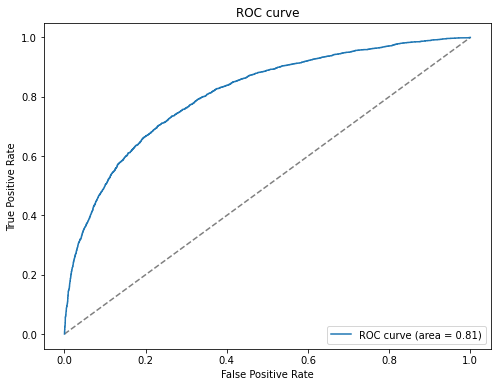

In [64]:
plot_roc_curve(rfc_2, X_test, y_test);

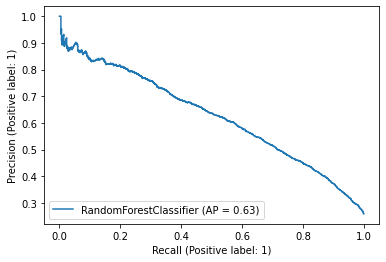

In [65]:
plot_precision_recall_curve(rfc_2, X_test, y_test);

### XGBoost

GradientBoost Accuracy= 0.80
Cross Validation Score = 0.80
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      8188
           1       0.70      0.44      0.54      2858

    accuracy                           0.80     11046
   macro avg       0.76      0.69      0.71     11046
weighted avg       0.79      0.80      0.79     11046



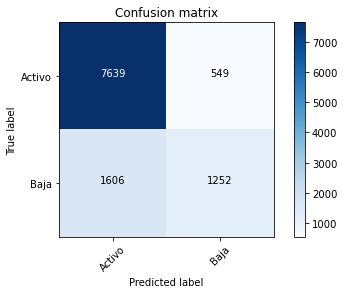

In [66]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=1000, booster='gbtree', learning_rate=0.01, objective='binary:logistic')
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print ("GradientBoost Accuracy= %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=5)
score_xgb = cross_val_score(xgb, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_xgb)

print(classification_report(y_test, y_pred))
result = classification_report(y_test, y_pred, output_dict=True)
recall_xgb = round(result['1']['recall'], 4)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

ROC AUC score: 0.82


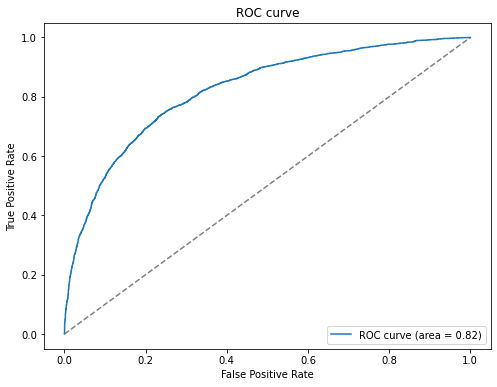

In [67]:
plot_roc_curve(xgb, X_test, y_test)

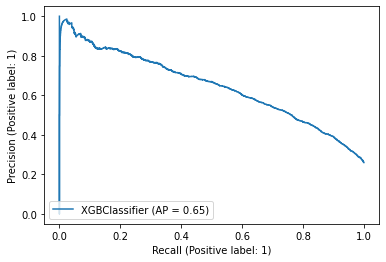

In [68]:
plot_precision_recall_curve(xgb, X_test, y_test);

### Voting Classifier

Utilizando la Regresión Logística, el Decission Tree Classifier y el Random Forest con los hiperparámetros tuneados.

VotingClassifier Accuracy= 0.75
Cross Validation Score = 0.74
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      8188
           1       0.51      0.71      0.60      2858

    accuracy                           0.75     11046
   macro avg       0.70      0.74      0.71     11046
weighted avg       0.79      0.75      0.76     11046



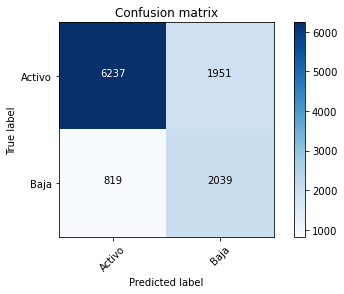

In [69]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
         ('lr', LR), ('rf', rfc_2), ('dt', DT)],
         voting='soft')

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print ("VotingClassifier Accuracy= %2.2f" % accuracy_score(y_test, y_pred))

skf = StratifiedKFold(n_splits=5)
score_voting_clf = cross_val_score(voting_clf, X_train, y_train, cv=skf).mean()
print("Cross Validation Score = %2.2f" % score_voting_clf)

print(classification_report(y_test, y_pred))
result = classification_report(y_test, y_pred, output_dict=True)
recall_voting = round(result['1']['recall'], 4)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=class_names, title='Confusion matrix')

In [70]:
filename = '../mvp_pkl/voting_clf_model.pkl'
voting_clf_model = voting_clf.fit(X_train, y_train)

pickle.dump(voting_clf_model, open(filename,'wb'))

ROC AUC score: 0.81


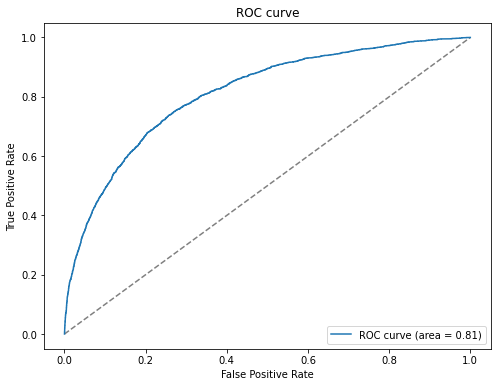

In [71]:
plot_roc_curve(voting_clf, X_test, y_test);

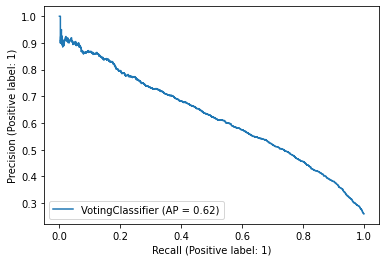

In [72]:
plot_precision_recall_curve(voting_clf, X_test, y_test);

### Comparing ROC Curves

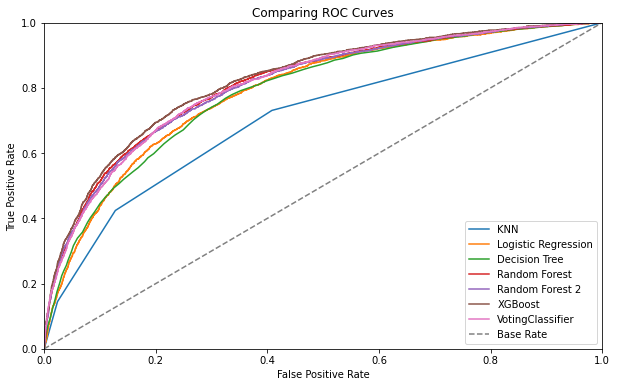

In [73]:
plt.figure(figsize = (10,6), linewidth= 1)

knn_fpr, knn_tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
LR_fpr, LR_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test)[:,1])
DT_fpr, DT_tpr, thresholds = roc_curve(y_test, DT.predict_proba(X_test)[:,1])
rfc_fpr, rfc_tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
rfc2_fpr, rfc2_tpr, thresholds = roc_curve(y_test, rfc_2.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
vc_fpr, vc_tpr, thresholds = roc_curve(y_test, voting_clf.predict_proba(X_test)[:,1])

plt.plot(knn_fpr, knn_tpr, label='KNN' )
plt.plot(LR_fpr, LR_tpr, label='Logistic Regression')
plt.plot(DT_fpr, DT_tpr, label='Decision Tree')
plt.plot(rfc_fpr, rfc_tpr, label='Random Forest')
plt.plot(rfc2_fpr, rfc2_tpr, label='Random Forest 2')
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost')
plt.plot(vc_fpr, vc_tpr, label='VotingClassifier')

plt.plot([0,1],[0,1],label='Base Rate', ls = '--', c = 'grey')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Comparing ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### Comparing PR Curves

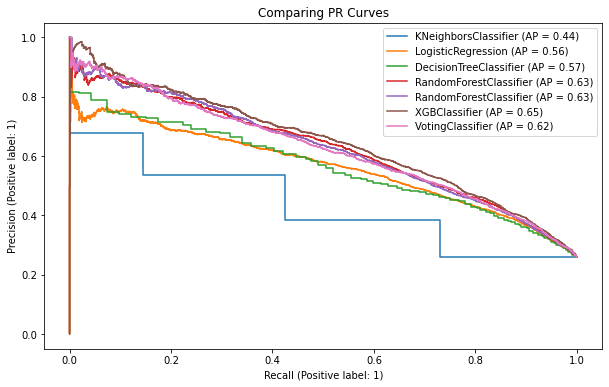

In [74]:
models = [knn, LR, DT, rfc, rfc_2, xgb, voting_clf]

fig, ax = plt.subplots(figsize=(10, 6))
for m in models:
    plot_precision_recall_curve(m, X_test, y_test, ax=ax)
    plt.legend(loc="upper right")
ax.set_title("Comparing PR Curves");

### Feature importances

In [75]:
from sklearn.feature_selection import RFE

# Using Recursive Feature Elimination Function and fitting it in a Logistic Regression Model
modell = LogisticRegression(max_iter=1000, class_weight="balanced")
rfe = RFE(modell, 5)
rfe = rfe.fit(X_train,y_train)

rfe.ranking_

C:\Users\alber\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([ 7,  1,  5,  9,  3,  8,  4,  1,  1, 10, 11,  1,  1,  2,  6])

In [76]:
result = zip(X_train.columns, rfe.ranking_)

result_set = set(result)
print(result_set)

{('Consumo_sca', 6), ('Quejas_sca', 1), ('Pagos Anuales', 11), ('Gender', 7), ('Pais', 4), ('Tipo Inmueble', 1), ('Precio Contado', 10), ('Precio Total', 1), ('Income', 1), ('Incidencias_sca', 2), ('Rango_Edad', 1), ('Estado Civil', 3), ('Tipo Propiedad', 5), ('Provincia', 8), ('Situacion Laboral', 9)}


[0.02604708 0.09514125 0.0411163  0.0462485  0.03633121 0.04404588
 0.03980302 0.08127784 0.07267991 0.0528029  0.04532956 0.04374932
 0.07707827 0.09354304 0.20480594]


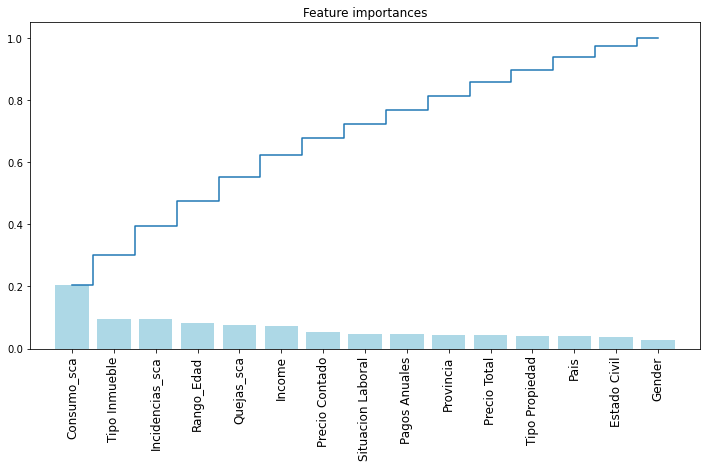

In [77]:
from sklearn.ensemble import ExtraTreesClassifier

# Using ExtraTreesClassifier model function
model = ExtraTreesClassifier()
model.fit(X_train, y_train)

# Printing important features in the model
print(model.feature_importances_)
importances = model.feature_importances_
feat_names = data_filtered.drop(['Estado'],axis=1).columns

# Displaying the feature importances as a chart by sorting it in the order of importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=12)
plt.xlim([-1, len(indices)])
plt.show()

### Results Resume

In [87]:
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Add table data
table_data = [['Model', 'Recall 1'],
              ['Logistic Regression', recall_lr],
              ['Decission Tree', recall_dt],
              ['RFC_1', recall_rfc],
              ['RFC_2', recall_rfc2],
              ['XGBoost', recall_xgb],
              ['Voting Class.', recall_voting]]

fig = ff.create_table(table_data, height_constant=60)

models = ['Logistic Regression', 'Decission Tree', 'RFC_1', 'RFC_2', 'XGBoost', 'Voting Class.']
recalls = [recall_lr, recall_dt, recall_rfc, recall_rfc2, recall_xgb, recall_voting]
              
# Make traces for graph
fig.add_trace(go.Bar(x=models, y=recalls,
                    marker=dict(color='#2256b5'),
                    name='Recall',
                    xaxis='x2', yaxis='y2'))

fig.update_layout(
    title_text = 'Recall de las Bajas de cada modelo',
    margin = {'t':50, 'b':100},
    xaxis = {'domain': [0, .3]},
    xaxis2 = {'domain': [0.4, 1.]},
    yaxis2 = {'anchor': 'x2', 'title': 'Recall'}
)

fig.show()